In [1]:
from pycococreatortools import pycococreatortools
import tifffile as tiff
import cv2
import os
import numpy as np
import json
import datetime


In [7]:
def show_img(img):
    cv2.imshow("img", img)
    cv2.waitKey()
    cv2.destroyAllWindows()

    # tiff.imshow(img)

In [3]:
def inspect_img(img):
    
    # inspect
    print(img.shape)
    print(img.max())
    print(img.dtype)
    print(type(img))
    for i in range(0, img.shape[0]):
        for j in range(1, img.shape[1]):
            if img[i, j] != 0:
                print(img[i, j])


int16


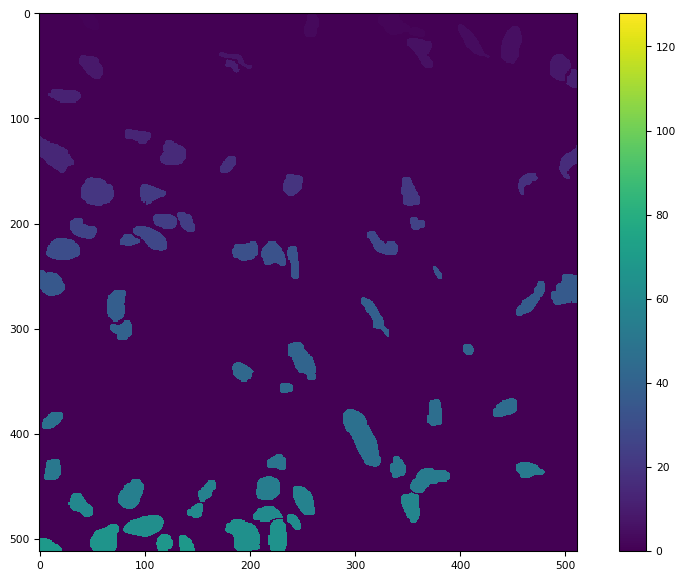

In [9]:
def read_img(path):
    img = tiff.imread(path) # np.ndarray

    return img


# read_img("data/cell-seg-data/test_fluo/IXMtest_A02_s1_w1051DAA7C-7042-435F-99F0-1E847D9B42CB.tif")
# x = read_img("data/cell-seg-data/test_tnbc/ann/Slide_01_1.tif")
# tiff.imshow(x)
# print(x[0:256, 0:256].dtype)

In [14]:
def generateCOCO(ROOT_DIR, IMAGE_DIR, ANNOTATION_DIR, output_file):
    INFO = {
        "description": "test",
        "url": "",
        "version": "0.1.0",
        "year": 2023,
        "contributor": "",
        "date_created": datetime.datetime.utcnow().isoformat(' ')
    }

    LICENSES = [
        {
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License",
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"
        }
    ]

    CATEGORIES = [
        {
            'id': 0,
            'name': 'background',
            'supercategory': 'background',
        },
        {
            'id': 1,
            'name': 'cell',
            'supercategory': 'cell',
        }
    ]

    coco_output = {
            "info": INFO,
            "licenses": LICENSES,
            "categories": CATEGORIES,
            "images": [],
            "annotations": []  # “一定要有cat=0的分类！但如果设bg=0，会使mAP值变小=> 改进：不设bg=0但把cell标签-1”
        }
    
    image_id = 1
    segmentation_id = 1
    for root, _, files in os.walk(IMAGE_DIR):   # 这个outer loop或许可以删除？

        for file in files:
            basename_no_extension = os.path.splitext(file)[0]

            img_path = os.path.join(IMAGE_DIR, basename_no_extension+".png")
            ann_path = os.path.join(ANNOTATION_DIR, basename_no_extension+".tif")
            # print("img path: ", img_path)
            # print("ann path: ", ann_path)

            # annotations[] - (1)
            ann = tiff.imread(ann_path)

            values = np.unique(ann) # cell vals
            values = np.delete(values, 0) # remove value of bg pixels
            # print("values: ", values)

            if len(values) == 0:
                continue

            # images[]
            img = cv2.imread(img_path)
            img_size = [img.shape[1], img.shape[0]]
                #会影响pycococreatortools里的resize process；
                # 也会影响self_segentor里的 training process

            image_info = pycococreatortools.create_image_info(
                image_id, file, img_size)
            coco_output["images"].append(image_info)

            # annotations[] - (2)
            for cell_id in values:
                category_info = {'id': 1, 'is_crowd': 0}

                ann_bimask = (ann == cell_id) * ann
                ann_bimask[ann_bimask != 0] = 1
                
                annotation_info = pycococreatortools.create_annotation_info(
                    segmentation_id, image_id, category_info, ann_bimask, 
                    img_size, tolerance=2)  
                
                if annotation_info is not None:
                    coco_output["annotations"].append(annotation_info)

                segmentation_id = segmentation_id + 1

            image_id = image_id + 1

    with open(output_file, 'w') as output_json_file:
        json.dump(coco_output, output_json_file)

'''test_tnbc'''
test_tnbc_root = 'data/cell-seg-data/test_patch_tnbc/'
test_tnbc_imgs = os.path.join(test_tnbc_root, "img")
test_tnbc_ann = os.path.join(test_tnbc_root, "ann")
test_tnbc_outputJson = os.path.join(test_tnbc_root, "tnbc.json")
# generateCOCO(test_tnbc_root, test_tnbc_imgs, test_tnbc_ann, test_tnbc_outputJson)

'''tnbc'''
tnbc_root = 'data/cell-seg-data/tnbc_patch/'

tnbc_imgs_train = os.path.join(tnbc_root, "img_train")
tnbc_ann_train = os.path.join(tnbc_root, "ann_train")
tnbc_outputJson_train = os.path.join(tnbc_root, "tnbc_train.json")

tnbc_imgs_test = os.path.join(tnbc_root, "img_test")
tnbc_ann_test = os.path.join(tnbc_root, "ann_test")
tnbc_outputJson_test = os.path.join(tnbc_root, "tnbc_test.json")

# generateCOCO(tnbc_root, tnbc_imgs_train, tnbc_ann_train, tnbc_outputJson_train)
# generateCOCO(tnbc_root, tnbc_imgs_test, tnbc_ann_test, tnbc_outputJson_test)

'''test_fluo'''
test_fluo_root = 'data/cell-seg-data/test_patch_fluo/'
test_fluo_imgs = os.path.join(test_fluo_root, "img")
test_fluo_ann = os.path.join(test_fluo_root, "ann")
test_fluo_outputJson = os.path.join(test_fluo_root, "fluo.json")
# generateCOCO(test_fluo_root, test_fluo_imgs, test_fluo_ann, test_fluo_outputJson)

'''Fluo'''
fluo_root = 'data/cell-seg-data/fluo_patch/'

fluo_imgs_test = os.path.join(fluo_root, "img_test")
fluo_ann_test = os.path.join(fluo_root, "ann_test")
fluo_outputJson_test = os.path.join(fluo_root, "fluo_test.json")

fluo_imgs_train = os.path.join(fluo_root, "img_train")
fluo_ann_train = os.path.join(fluo_root, "ann_train")
fluo_outputJson_train = os.path.join(fluo_root, "fluo_train.json")

fluo_imgs_val = os.path.join(fluo_root, "img_val")
fluo_ann_val = os.path.join(fluo_root, "ann_val")
fluo_outputJson_val = os.path.join(fluo_root, "fluo_val.json")

generateCOCO(fluo_root, fluo_imgs_test, fluo_ann_test, fluo_outputJson_test)
generateCOCO(fluo_root, fluo_imgs_train, fluo_ann_train, fluo_outputJson_train)
generateCOCO(fluo_root, fluo_imgs_val, fluo_ann_val, fluo_outputJson_val)
